# Supervised Pixel Classification

The objective of this notebook is to employ a supervised classification technique, namely, the Random Forest algorithm to classify a temporal series dataset.

In [1]:
!gdown https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF -O USE_CASE_2.zip

Downloading...
From: https://drive.google.com/uc?id=1G6e681hlmsQTxlUJIMjJmxso9s5L-SgF
To: /content/USE_CASE_2.zip
100% 152M/152M [00:01<00:00, 83.7MB/s]


In [4]:
#!unzip USE_CASE_2.zip

In [ ]:
# ! pip3 install shap==0.39.0

In [6]:
import os
import numpy as np
import tifffile as tiff
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
# from utils import shuffle_two_arrays,evaluate,array2raster,create_directory
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from osgeo import gdal,gdal_array,osr,ogr
from osgeo import gdal
from os.path import join
import cv2
import pprint
# %matplotlib notebook

# Functions definition

In [7]:
def shuffle_two_arrays(img, msk):
    rng_state = np.random.get_state()
    np.random.shuffle(img)
    np.random.set_state(rng_state)
    np.random.shuffle(msk)
    return img, msk

In [8]:
def evaluate(model, X_test, y_test):
    yhat = model.predict(X_test)
    accuracy = accuracy_score(y_test,yhat)
    f_score = f1_score(y_test,yhat,average='weighted')
    p_score = precision_score(y_test,yhat,average='weighted')
    r_score = recall_score(y_test,yhat,average='weighted')
    confusion_mat = confusion_matrix(y_test,yhat)

    print ('accuracy',accuracy)
    print ('f1 score',f_score)
    print ('precision',p_score)
    print ('recall',r_score)
    print ('confusion matrix',confusion_mat)
    return accuracy,f_score,p_score,confusion_mat

In [9]:
def array2raster(newRasterfn, dataset, array, dtype):
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte":
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
        if band_num == 1:
            outband.WriteArray(array)
        else:
            outband.WriteArray(array[:,:,b])

    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

In [10]:
def create_directory(folder_name):
    if not os.path.exists(folder_name):
        try:
            os.mkdir(folder_name)
        except OSError as exc:
            if exc.errno!=errno.EEXIST:
                raise

# Code

In [11]:
img1_path = './USE_CASE_2/image_dataset/training_data/inpainted_img1.tif'
img2_path = './USE_CASE_2/image_dataset/training_data/inpainted_img2.tif'
label_path = './USE_CASE_2/image_dataset/training_data/sicoval_training.tif'
output_path = './USE_CASE_2/image_dataset/pixel_classification'
#create_directory(output_path)

In [12]:
img1 = tiff.imread(img1_path)
img2 = tiff.imread(img2_path)
label_img = tiff.imread(label_path)

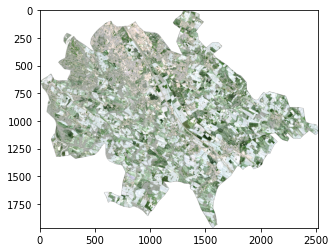

In [13]:
plt.figure(1)
plt.imshow(img1)
plt.show()

In [14]:
img1.shape

(1967, 2520, 4)

In [15]:
pixels_img1 = img1[label_img>0]
pixels_img2 = img2[label_img>0]
labels = label_img[label_img>0]

print (pixels_img1.shape)
print (pixels_img2.shape)
print (labels.shape)

## ATTENTION il a transforme la matrice en vecteur

(7509, 4)
(7509, 4)
(7509,)


In [16]:
pixels = np.zeros((labels.shape[0],8),dtype=np.float32)
pixels[:,0:4] = np.copy(pixels_img1)
pixels[:,4:] = np.copy(pixels_img2)
print (pixels, '\n', pixels.shape)

[[0.08523908 0.10465116 0.02756339 ... 0.21672828 0.13848117 0.10711091]
 [0.09043659 0.10259918 0.03362734 ... 0.21441774 0.13178048 0.10263864]
 [0.09147609 0.0868673  0.02646086 ... 0.22227357 0.15698788 0.12186941]
 ...
 [0.68087316 0.54103965 0.44873208 ... 0.45286506 0.36439055 0.3752236 ]
 [0.62889814 0.50889194 0.46196252 ... 0.3909427  0.27536693 0.5690966 ]
 [0.69542617 0.5875513  0.47464168 ... 0.5304991  0.34077856 0.3881932 ]] 
 (7509, 8)


In [17]:
labels

array([2, 2, 2, ..., 1, 1, 1], dtype=uint8)

In [18]:
print (labels)
print (pixels)
pixels,labels = shuffle_two_arrays(pixels,labels) 
# pour chaque arbre il faut prendre un sample de chaque classe, il faut pour ca melanger les donnees
print (labels)
print (pixels)

[2 2 2 ... 1 1 1]
[[0.08523908 0.10465116 0.02756339 ... 0.21672828 0.13848117 0.10711091]
 [0.09043659 0.10259918 0.03362734 ... 0.21441774 0.13178048 0.10263864]
 [0.09147609 0.0868673  0.02646086 ... 0.22227357 0.15698788 0.12186941]
 ...
 [0.68087316 0.54103965 0.44873208 ... 0.45286506 0.36439055 0.3752236 ]
 [0.62889814 0.50889194 0.46196252 ... 0.3909427  0.27536693 0.5690966 ]
 [0.69542617 0.5875513  0.47464168 ... 0.5304991  0.34077856 0.3881932 ]]
[3 4 5 ... 4 1 1]
[[0.43451142 0.5389877  0.42723262 ... 0.8724584  0.9010849  0.9027281 ]
 [0.4927235  0.5389877  0.5363837  ... 0.4417745  0.27377152 0.65339893]
 [0.24948025 0.3132695  0.27067256 ... 0.22781885 0.12061264 0.76610017]
 ...
 [0.92515594 0.98084813 1.         ... 0.5184843  0.33631143 0.9148032 ]
 [0.26091477 0.31668946 0.25303197 ... 0.41173753 0.31429484 0.5921288 ]
 [0.3898129  0.4131327  0.3792723  ... 0.35536045 0.2890874  0.5992844 ]]


In [19]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.25, random_state=1)

In [20]:
print ("X train shape",X_train.shape)
print ("y train shape",y_train.shape)
print ("unique labels train",np.unique(y_train,return_counts=True))
print ("X test shape",X_test.shape)
print ("y test shape",y_test.shape)
print ("unique labels test",np.unique(y_test,return_counts=True))

X train shape (5631, 8)
y train shape (5631,)
unique labels train (array([1, 2, 3, 4, 5], dtype=uint8), array([2175,  207,  801, 1448, 1000]))
X test shape (1878, 8)
y test shape (1878,)
unique labels test (array([1, 2, 3, 4, 5], dtype=uint8), array([711,  75, 252, 517, 323]))


## Random search method

In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp = pprint.PrettyPrinter()
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [22]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid,
                               n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
rf_random.best_params_

In [ ]:
base_model = RandomForestClassifier(n_estimators = 2, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

In [ ]:
best_random = rf_random.best_estimator_
_,_,_,_ = evaluate(best_random, X_test, y_test)

## Grid search method

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

In [ ]:
explainer = shap.TreeExplainer(best_grid) # initialisation de explainer
# TreeExplainer explication de ce qu'il se passe dans RandomForest
shap_values = explainer.shap_values(X_test)

In [ ]:
# Feature importance derived from SHAP for each class
plt.figure(10)
#shap.summary_plot(shap_values[4], X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# interaction between a specific features and other features in the dataset and the correlation with the target variable for class 0
plt.figure(2)
shap.dependence_plot("Feature 6", shap_values[4], X_test)

In [ ]:
# interaction between a specific features and other features in the dataset and the correlation with the target variable for class 0
plt.figure(2)
shap.dependence_plot("Feature 6", shap_values[4], X_test)

In [ ]:
# to convert f(x) to probability p=e^x/(1 + e^x)
cl = 0
plt.figure(3)
shap.initjs()
shap.force_plot(explainer.expected_value[cl], shap_values[cl], X_test)

Il faut transformer l'image 3D en 2D. On multiplie les 2 premières coordonnées.

In [ ]:
pixels1 = np.reshape(img1,(img1.shape[0]*img1.shape[1],img1.shape[2]))
pixels2 = np.reshape(img2,(img2.shape[0]*img2.shape[1],img2.shape[2]))
all_pixels = np.zeros((pixels1.shape[0],8),dtype=np.float32)
all_pixels[:,0:4] = np.copy(pixels1)
all_pixels[:,4:] = np.copy(pixels2)
img_labels = best_grid.predict(all_pixels)

In [ ]:
pixels2.shape

In [ ]:
img_labels.shape

In [ ]:
np.unique(img_labels, return_counts=True)

In [ ]:
img1.shape[:-1]

In [ ]:
out_arr = np.reshape(img_labels,img1.shape[:-1])

In [ ]:
out_arr.shape

In [ ]:
plt.figure(4)
plt.imshow(out_arr)

In [ ]:
new_arr = np.copy(out_arr)
new_arr[img1[...,0]==0] = 0 # remettre les valeurs no_data egales a 0

## Save un np.array comme une image referencee
dataset = gdal.Open(img1_path)
output_fname = join(output_path,'pixel_classification.tif')
array2raster(output_fname,dataset,new_arr,'Byte')

# Etape post-traitement
Les pixels sel-poivre, qui sont bizarre autour de pixels avec des valeurs vraiment très différent.
Appliquer median filter.

In [ ]:
median_arr = cv2.medianBlur(out_arr, 3)
median_arr[img1[...,0]==0] = 0
output_fname = join(output_path,'pixel_classification_filtered.tif')
array2raster(output_fname,dataset,median_arr,'Byte')

In [ ]:
plt.figure(3)
plt.imshow(median_arr)

In [ ]:
plt.figure(4)
plt.imshow(new_arr)